In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import math
from scipy import stats
from numpy import absolute
from numpy import mean
from sklearn import metrics
import pickle

In [2]:
df = pd.read_csv('web_flight_final.csv')

In [3]:
df

,Unnamed: 0,airline,duration,total_stops,price,date_of_journey,depature_time,sources,arrival_time,desinations
0,0,Air Asia,6h 35m,1 Stop,"5,953",23-10-2021,09:25,New Delhi,16:00,Mumbai
1,1,Air Asia,7h 35m,1 Stop,"5,953",23-10-2021,12:40,New Delhi,20:15,Mumbai
2,2,Air Asia,8h 20m,1 Stop,"5,953",23-10-2021,11:55,New Delhi,20:15,Mumbai
3,3,Air Asia,11h 40m,1 Stop,"5,953",23-10-2021,18:40,New Delhi,06:20,+ 1 day\nMumbai
4,4,Air Asia,14h 10m,1 Stop,"5,953",23-10-2021,08:00,New Delhi,22:10,Mumbai
...,...,...,...,...,...,...,...,...,...,...
1639,1639,Air Asia,14h 15m,1 Stop,"16,313",27-12-2021,12:10,New Delhi,02:25,+ 1 day\nMumbai
1640,1640,Air India,13h 40m,1 Stop,"17,127",27-12-2021,10:55,New Delhi,00:35,+ 1 day\nMumbai
1641,1641,Air India,21h 50m,1 Stop,"17,127",27-12-2021,10:55,New Delhi,08:45,+ 1 day\nMumbai
1642,1642,Air India,5h 40m,1 Stop,"18,282",27-12-2021,10:55,New Delhi,16:35,Mumbai


In [4]:
df["price"] = [float(str(i).replace(",", "")) for i in df["price"]]

In [5]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [6]:
df["duration"].value_counts()

2h 10m     195
2h 15m     163
2h 20m     100
2h 05m      49
2h 25m      26
          ... 
23h 20m      1
28h 00m      1
19h 55m      1
25h 05m      1
14h 30m      1
Name: duration, Length: 185, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1644 entries, 0 to 1643
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          1644 non-null   object 
 1   duration         1644 non-null   object 
 2   total_stops      1644 non-null   object 
 3   price            1644 non-null   float64
 4   date_of_journey  1644 non-null   object 
 5   depature_time    1644 non-null   object 
 6   sources          1644 non-null   object 
 7   arrival_time     1644 non-null   object 
 8   desinations      1644 non-null   object 
dtypes: float64(1), object(8)
memory usage: 115.7+ KB


In [8]:
df.isnull().sum()

airline            0
duration           0
total_stops        0
price              0
date_of_journey    0
depature_time      0
sources            0
arrival_time       0
desinations        0
dtype: int64

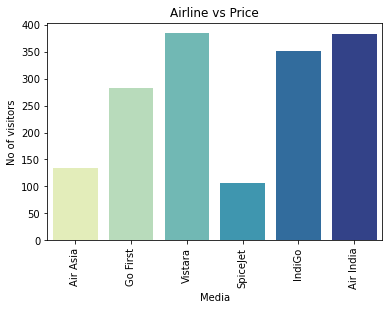

In [9]:
sns.countplot(x='airline',data=df,palette='YlGnBu')
plt.title("Airline vs Price")
plt.xlabel("Media")
plt.ylabel("No of visitors")
plt.xticks(rotation=90)
plt.show()

From the above graph we can able to conclude Air india and Vistara have more number of passengers then others

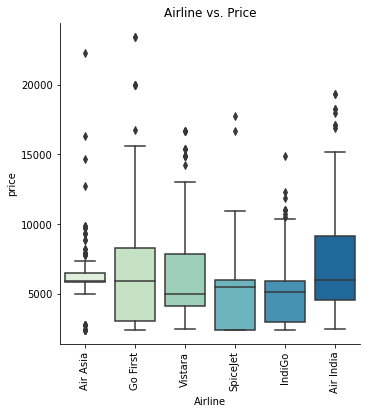

In [10]:

sns.catplot(data=df[['airline','price']],x='airline',y='price',kind='box',palette='GnBu')
plt.ylabel("price")
plt.xlabel("Airline")
plt.title("Airline vs. Price")
plt.xticks(rotation=90)
plt.show()

The above graph tells that the Air india have highest price range than the other.

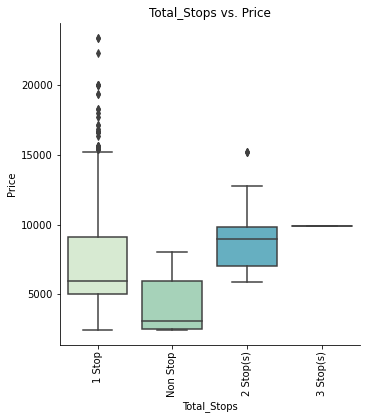

In [11]:
sns.catplot(data=df[['total_stops','price']],x='total_stops',y='price',kind='box',palette='GnBu')
plt.ylabel("Price")
plt.xlabel("Total_Stops")
plt.title("Total_Stops vs. Price")
plt.xticks(rotation=90)
plt.show()

From the above graph we can conclude that more the stops more the price

In [12]:
df["Journey_day"]=pd.to_datetime(df["date_of_journey"],format="%d-%m-%Y").dt.day
df["Journey_month"]=pd.to_datetime(df["date_of_journey"],format="%d-%m-%Y").dt.month

In [14]:
df.drop(columns='date_of_journey',axis=1,inplace=True)

In [15]:
df['total_stops'].value_counts()

1 Stop       1035
Non Stop      577
2 Stop(s)      31
3 Stop(s)       1
Name: total_stops, dtype: int64

In [16]:
df.replace({"Non Stop":0,"1 Stop":1,"2 Stop(s)":2,"3 Stop(s)":3},inplace=True)

In [18]:
df["Dep_hour"]=pd.to_datetime(df["depature_time"]).dt.hour
df["Dep_mins"]=pd.to_datetime(df["depature_time"]).dt.minute

In [21]:
df["Arr_hour"]=pd.to_datetime(df["arrival_time"]).dt.hour
df["Arr_min"]=pd.to_datetime(df["arrival_time"]).dt.minute

In [23]:
df.drop(columns='arrival_time',axis=1,inplace=True)

In [24]:
df=pd.get_dummies(df,columns=['airline','sources','desinations'],drop_first=True)

In [26]:
df.drop(columns='depature_time',axis=1,inplace=True)

In [27]:
df['total_stops'].value_counts()

1    1035
0     577
2      31
3       1
Name: total_stops, dtype: int64

In [28]:
duration=list(df['duration'])

for i in range(len(duration)):
    if len(duration[i].split()) !=2:
        if "h" in duration[i]:
            duration[i]=duration[i].strip()+" 0m"
        else:
            duration[i]="0h "+duration[i]

duration_hours=[]
duration_mins=[]
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep="h")[0]))
    duration_mins.append(int(duration[i].split(sep="m")[0].split()[-1]))

In [29]:

df['Duration_hours']=duration_hours
df['Duration_mins']=duration_mins

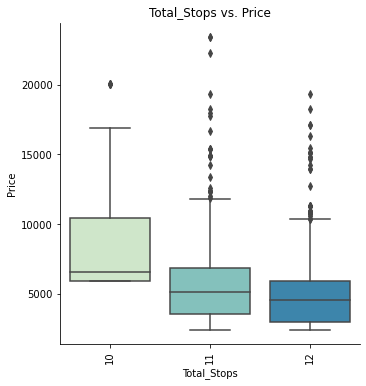

In [31]:
sns.catplot(data=df[['Journey_month','price']],x='Journey_month',y='price',kind='box',palette='GnBu')
plt.ylabel("Price")
plt.xlabel("Total_Stops")
plt.title("Total_Stops vs. Price")
plt.xticks(rotation=90)
plt.show()

Price of the ticket decreases as the booking is earlier in the present situation December is cheapest because it is after three months  

In [32]:
df.drop(columns='duration',axis=1,inplace=True)

In [33]:
df.head()

,total_stops,price,Journey_day,Journey_month,Dep_hour,Dep_mins,Arr_hour,Arr_min,airline_Air India,airline_Go First,airline_IndiGo,airline_SpiceJet,airline_Vistara,desinations_+ 2 days\nMumbai,desinations_Mumbai,Duration_hours,Duration_mins
0,1,5953.0,23,10,9,25,16,0,0,0,0,0,0,0,1,6,35
1,1,5953.0,23,10,12,40,20,15,0,0,0,0,0,0,1,7,35
2,1,5953.0,23,10,11,55,20,15,0,0,0,0,0,0,1,8,20
3,1,5953.0,23,10,18,40,6,20,0,0,0,0,0,0,0,11,40
4,1,5953.0,23,10,8,0,22,10,0,0,0,0,0,0,1,14,10


In [34]:

X=df.drop(columns='price',axis=1,)
y=df['price']

In [35]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

Decision Tree Score on Training set is 1.0
Decision Tree Score on Test Set is 0.5426768544925871
[0.42269988 0.54494044 0.66368495 0.6028112  0.46242257]
Accuracy: 53.93 %
Standard Deviation: 8.84 %
Mean Absolute Error: 1083.1063829787233
Mean Squared Error: 5589125.386018237
RMSE: 2364.1331151223776
The r2_score is 0.5426768544925871


C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


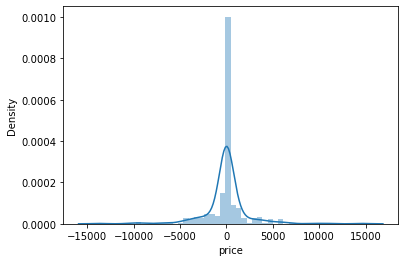

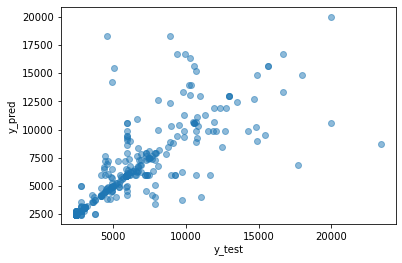

In [37]:
from sklearn.tree import DecisionTreeRegressor
dt_reg = DecisionTreeRegressor(random_state = 0)
dt_reg.fit(X_train, y_train)
y_pred=dt_reg.predict(X_test)

print("Decision Tree Score on Training set is",dt_reg.score(X_train, y_train))#Training Accuracy
print("Decision Tree Score on Test Set is",dt_reg.score(X_test, y_test))#Testing Accuracy

accuracies = cross_val_score(dt_reg, X_train, y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

mae=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:" , mae)

mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:" , mse)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('The r2_score is', metrics.r2_score(y_test, y_pred))

sns.distplot(y_test-y_pred)
plt.show()

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

Random Forest Score on Training set is 0.8352993875401366
Random Forest Score on Test Set is 0.7354831941246596
[0.69425732 0.6613142  0.74558153 0.68705689 0.69180519]
Accuracy: 69.60 %
Standard Deviation: 2.74 %
Mean Absolute Error: 1027.133932995749
Mean Squared Error: 3232763.5486412505
RMSE: 1797.9887509773944
The r2_score is 0.7354831941246596


C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


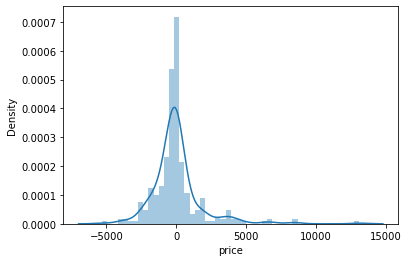

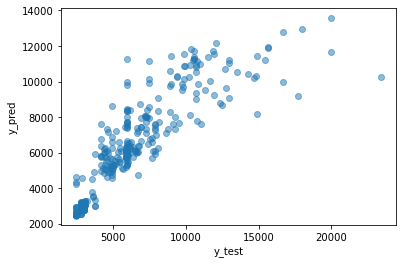

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(n_estimators=400,min_samples_split=15,min_samples_leaf=2,
max_features='auto', max_depth=30)
rf_reg.fit(X_train, y_train)
y_pred=rf_reg.predict(X_test)

print("Random Forest Score on Training set is",rf_reg.score(X_train, y_train))#Training Accuracy
print("Random Forest Score on Test Set is",rf_reg.score(X_test, y_test))#Testing Accuracy

accuracies = cross_val_score(rf_reg, X_train, y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

mae=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:" , mae)

mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:" , mse)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('The r2_score is', metrics.r2_score(y_test, y_pred))

sns.distplot(y_test-y_pred)
plt.show()

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

Voting Regresssor Score on Training set is 0.9584077099062511
Voting Regresssor Score on Test Set is 0.7118937355099375
[0.63186213 0.65202501 0.76024895 0.70765186 0.66856582]
Accuracy: 68.41 %
Standard Deviation: 4.55 %
Mean Absolute Error: 1010.2716369892362
Mean Squared Error: 3521059.567071904
RMSE: 1876.4486582563095
The r2_score is 0.7118937355099375


C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


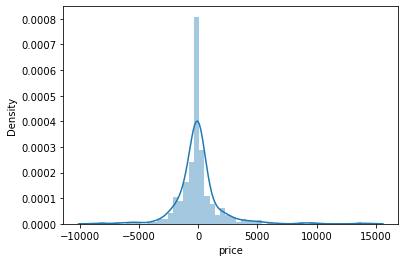

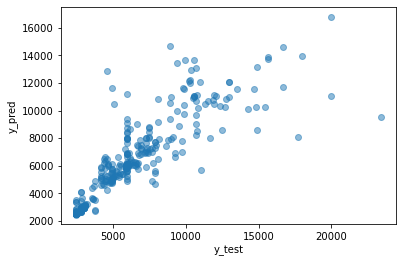

In [39]:
from sklearn.ensemble import VotingRegressor
vot_reg = VotingRegressor([('DecisionTree', dt_reg), ('RandomForestRegressor', rf_reg)])
vot_reg.fit(X_train, y_train)
y_pred=vot_reg.predict(X_test)

print("Voting Regresssor Score on Training set is",vot_reg.score(X_train, y_train))#Training Accuracy
print("Voting Regresssor Score on Test Set is",vot_reg.score(X_test, y_test))#Testing Accuracy

accuracies = cross_val_score(vot_reg, X_train, y_train, cv = 5)
print(accuracies)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

mae=mean_absolute_error(y_pred, y_test)
print("Mean Absolute Error:" , mae)

mse=mean_squared_error(y_test, y_pred)
print("Mean Squared Error:" , mse)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

print('The r2_score is', metrics.r2_score(y_test, y_pred))

sns.distplot(y_test-y_pred)
plt.show()

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

C:\Users\Hp\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


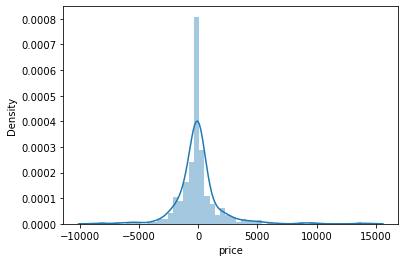

In [40]:
sns.distplot(y_test-y_pred)
plt.show()

In [41]:
print('MAE: ', metrics.mean_absolute_error(y_test,y_pred))
print('MSE: ', metrics.mean_squared_error(y_test,y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))

MAE:  1010.2716369892362
MSE:  3521059.567071904
RMSE:  1876.4486582563095


In [42]:

metrics.r2_score(y_test,y_pred)

0.7118937355099375

In [43]:
n_estimators=[int(x) for x in np.linspace(start = 100, stop = 1200, num=12)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(5, 30,num=6)]
min_samples_split=[2,5,10,15,100]
min_sample_leaf =[1,2,5,10]

In [44]:
random_grid={'n_estimators': n_estimators,
            'max_features': max_features,
            'max_depth' : max_depth,
            'min_samples_split': min_samples_split,
            'min_samples_leaf': min_sample_leaf}

In [46]:
rf_reg=RandomizedSearchCV(estimator=rf_reg,param_distributions=random_grid,scoring='neg_mean_squared_error',n_iter = 10,cv=5,random_state=42,n_jobs=1)

In [47]:
rf_reg.fit(X_train,y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=30,
                                                   min_samples_leaf=2,
                                                   min_samples_split=15,
                                                   n_estimators=400),
                   n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
   

In [48]:
rf_reg.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 25}

In [49]:
prediction = rf_reg.predict(X_test)

In [50]:
print('MAE: ', metrics.mean_absolute_error(y_test,prediction))
print('MSE: ', metrics.mean_squared_error(y_test,prediction))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test,prediction)))


MAE:  910.7419984802432
MSE:  2843173.729791642
RMSE:  1686.171322787706


# Save the model

In [51]:
file=open('flight_prediction.pkl','wb')
pickle.dump(rf_reg,file)

In [52]:
model = open('flight_prediction.pkl','rb')
forest = pickle.load(model)

In [53]:
y_prediction=forest.predict(X_test)

In [54]:
metrics.r2_score(y_test,y_prediction)

0.7673608903845561

In [56]:
file=open('flight_prediction2.pkl','wb')
pickle.dump(rf_reg,file)